# Selecting Logan Search results by Sequencing Technology using Python in Jupyter

This notebook demonstrates how you could filter Logan Search Results by technolgy.

This assumes you have worked through [Working with with Logan Search results in Jupyter](Working_with_Logan_Search_results_with_Python_in_Jupyter.ipynb). If you haven't yet, please do that first.   
Indeed the first code cell below is directly from the first cell [there](Working_with_Logan_Search_results_with_Python_in_Jupyter.ipynb).


----------

#### Reading in the results for several queries

Run the code in the next cell assigning the settings to match the set-up preparation performed and to bring in the results data to the active namespace:


In [1]:
results_dir = "/home/jovyan/logan_search_results/"
consistent_part_of_file_name_suffix = "_31mer_"

import os
import fnmatch
import pandas as pd

def extract_tags_from_filename(filename):
    '''
    extract tag labels from file names

    return the tag label
    '''
    first_part = filename.split(consistent_part_of_file_name_suffix,1)[0]
    all_but_first_part_of_remainder_as_list = first_part.split("_")[1:]
    return "_".join(all_but_first_part_of_remainder_as_list)
    
matched_filenames = []
file_tags_per_file = []
dfs = []
for file in sorted(os.listdir(results_dir)):
    if fnmatch.fnmatch(file, '*.tsv'):
        matched_filenames.append(file)
        file_tags_per_file.append(extract_tags_from_filename(file))
        dfs.append(pd.read_csv(results_dir + file, sep="\t"))

# provide feedback about what was read in
max_filename_length = max(len(filename) for filename in matched_filenames)
for filename, df in zip(matched_filenames, dfs): 
    print(f'from {filename}:{" " * (max_filename_length - len(filename))} {len(df):>6} rows read in')

#print(file_tags_per_file) # FOR DEBUGGING, uncomment
#print(matched_filenames) # FOR DEBUGGING, uncomment
gene_name = file_tags_per_file[0].split("_",1)[0]
# make tuples of tag labels and corresponding dataframes
tags_and_dataframes = list(zip(file_tags_per_file, dfs)) # tags are first in each two-item tuple, the dataframe is second
# make dictionary of tuples of tag labels and corresponding dataframes, integers will be the keys with the tuples as values
tags_and_dataframes_dict = dict(zip(range(len(file_tags_per_file)), zip(file_tags_per_file, dfs))) # integers ('index') are keys with tags are first in each two-item tuple, the dataframe is second
print(f"\nTOTAL QUERY RESULTS READ IN: {len(file_tags_per_file)}")

from human_USP7_RET_I_31mer_logan_results.tsv:       19999 rows read in
from human_USP7_SJ_14n15_31mer_logan_results.tsv:    19999 rows read in
from human_USP7_SJ_34_31mer_logan_results.tsv:       19997 rows read in
from human_USP7_TSL4_altSJ_31mer_logan_results.tsv:  19997 rows read in

TOTAL QUERY RESULTS READ IN: 4


--------

## Selecting based on Sequencing Technology

#### Step #1 add a type column based on Instrument used

In step #1, we'll add and additional column to the data based on the `Instruments` column.  
To do that first we have to bring in a table that has the technology instruments.  
Run the cell below to read the the comma-separated values file (.csv) that contains the details on the instruments that are seen in the results from Logan Search results:

In [2]:
import pandas as pd
instr_dets_df = pd.read_csv("supporting_tables_and_data/sequencing_instrument_details_for_all_SRA_options_seen_thus_far.csv")
instrument_to_type_dict = dict(zip(instr_dets_df['Instrument'],instr_dets_df['Read Type']))
#instr_dets_df.head() #Uncomment this line to display the first five lines of the dataframe made from `.csv` file

Now we are ready to do the assignment step.

The following cell should add a column 'reads_type' based on the `instr_dets` dataframe.

In [3]:
for df in dfs:
    #df['Read Type'] = df['instrument'].apply(instrument_to_type)
    df['reads_type'] = df['instrument'].map(instrument_to_type_dict)

If you later edit this notebook to repeat it with your own results, keep in mind tha assignment step may fail. Whike an effort was made to make it fairly extensive, the table may not be complete at this time. If you see an error here it may be that there is no match for an instrument listed in your results among the list supplied here. To fix it though, you should be able to edit the comma-separated values file [there](supporting_tables_and_data/sequencing_instrument_details_for_all_SRA_options_seen_thus_far.csv), save it, and run the code again.

Let's run the following code to see that a new 'reads_type' column has been added to the first dataframe:

Now with that column added, we can use it to subset a dataframe in whcih we are interested.

#### Step #2 Select on the technology type

We'll filter the human results for 'RET_I' based on if the sequencing reads type is '`Long`'. 

In [4]:
reti_df = tags_and_dataframes_dict[0][1]
human_reti_df = reti_df.query("organism == 'Homo sapiens'")
print(f"There's {len(human_reti_df)} human accessions in the 'RET_I' results.")
human_long_reads_for_reti_df = human_reti_df.query("reads_type == 'Long'")
print(f"Out of those {len(human_reti_df)}, there's {len(human_long_reads_for_reti_df)} 'long-read' ones.")
human_long_reads_for_reti_df

There's 6059 human accessions in the 'RET_I' results.
Out of those 6059, there's 2 'long-read' ones.


,ID,kmer_coverage,bioproject,biosample,bioproject_title,bioproject_description,sample_acc,assay_type,center_name,experiment,...,avgspotlen,mbases,biosamplemodel_sam,collection_date_sam,location_count,location_avg_coverage,location_max_coverage,location_min_coverage,location_med_coverage,reads_type
13338,SRR23849628,1,PRJNA906114,SAMN33743856,Counting and correcting errors within unique m...,Unique Molecular Identifiers (UMIs) are random...,SRS17033009,RNA-Seq,"WIMM, UNIVERSITY OF OXFORD",SRX19662564,...,1662,10715,NaN,NaN,0,NaN,NaN,NaN,NaN,Long
17203,SRR17180614,1,PRJNA787547,SAMN23818454,Isoform-resolved transcriptome of the human pr...,Human preimplantation development is a complex...,SRS11268727,RNA-Seq,GEO,SRX13363940,...,987,648,NaN,NaN,0,NaN,NaN,NaN,NaN,Long


We see two aaccessions have 'Long' for the reads type.

The produced dataframe could be used to consider possibe SRA entries to investigate further.

For example, you may prefer a BioProject / BioSample set that had both long and short reads.
Looking at one BioProject identified among the eight with long reads for `alt_SJ` analyzed separately from here, we can see that is the case for BioProject `PRJEB42052`.

In [5]:
alt_SJ_df = tags_and_dataframes_dict[3][1]
alt_SJ_df.query("bioproject == 'PRJEB42052'")

,ID,kmer_coverage,bioproject,biosample,bioproject_title,bioproject_description,sample_acc,assay_type,center_name,experiment,...,avgspotlen,mbases,biosamplemodel_sam,collection_date_sam,location_count,location_avg_coverage,location_max_coverage,location_min_coverage,location_med_coverage,reads_type
385,ERR5654683,1,PRJEB42052,SAMEA8492555,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177360,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370174,...,102,3795,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
3086,ERR5670887,1,PRJEB42052,SAMEA8515329,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6200127,OTHER,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5386380,...,1669,753,NaN,NaN,43,1.0,1.0,1.0,1.0,Long
3863,ERR5654602,1,PRJEB42052,SAMEA8492555,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177360,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370093,...,102,4018,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
5002,ERR5654698,1,PRJEB42052,SAMEA8492553,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177358,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370189,...,102,3978,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
5881,ERR5654700,1,PRJEB42052,SAMEA8492553,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177358,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370191,...,102,4529,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
6942,ERR5654687,1,PRJEB42052,SAMEA8492555,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177360,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370178,...,102,7816,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
11017,ERR5654690,1,PRJEB42052,SAMEA8492553,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177358,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370181,...,102,4513,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
13938,ERR5654686,1,PRJEB42052,SAMEA8492555,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177360,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370177,...,102,5974,NaN,NaN,43,1.0,1.0,1.0,1.0,Short
16769,ERR5654685,1,PRJEB42052,SAMEA8492553,Targeting the m6A RNA modification pathway blo...,N6-methyladenosine (m6A) is an abundant intern...,ERS6177358,RIP-Seq,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,ERX5370176,...,102,3957,NaN,NaN,43,1.0,1.0,1.0,1.0,Short


That would be how you select by Sequencing Technology.  
Next, I want to end this notebook exploring a point raised by that dataframe.

------

-----

You may note that the results of `alt_SJ_df.query("bioproject == 'PRJEB42052'")` shows two BioSamples.

The same BioProject being attached to several accessions points out that although, to this point, I have been treating the accessions in ways that may make them seen largely independent, many of them are related.  

We can show that for the first dataframe, and right before that we'll print a summary about that column based on `df.describe()`:

BioProject Entries Summary:
count                   19982
unique                   2238
top                PRJEB14362
freq                     2298
unique_with_nan          2239
Name: bioproject, dtype: object
There's 15 NaN ('Not a number') entries in the 'BioProject' column out of 19997 rows.


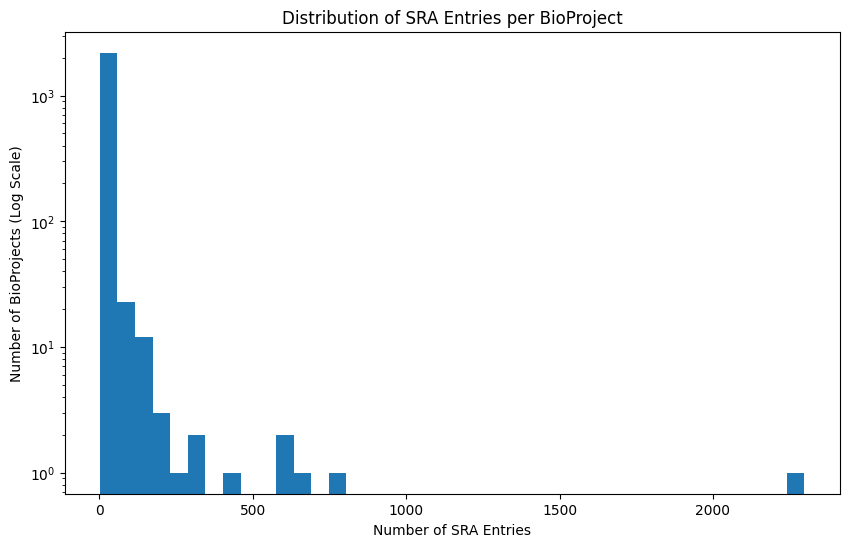

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df = alt_SJ_df
bioproject_counts = df['bioproject'].value_counts() # Calculate SRA entries per BioProject
plot_data = pd.DataFrame({'bioproject_counts': bioproject_counts.values}) # Create a DataFrame for plotting

print("BioProject Entries Summary:")
bioproject_desc = df['bioproject'].describe(include='all')
unique_counts_including_nan = df['bioproject'].nunique(dropna=False) # Calculate the unique counts including NaN

# Add the unique counts to the describe output - this is to overcome that Pandas distinguishes between statistical uniqueness (used by `describe()`) and simple value uniqueness (used by `unique()`).
bioproject_desc.loc['unique_with_nan'] = unique_counts_including_nan
print(bioproject_desc)
if bioproject_desc['unique'] < unique_counts_including_nan:
    print(f"There's {int(df['bioproject'].isna().sum())} NaN ('Not a number') entries in the 'BioProject' column out of {len(df)} rows.")

plt.figure(figsize=(10, 6))
plt.hist(plot_data['bioproject_counts'], bins=40, log=True)
plt.title('Matplotlib log=True')
plt.title('Distribution of SRA Entries per BioProject')
plt.xlabel('Number of SRA Entries')
plt.ylabel('Number of BioProjects (Log Scale)')
plt.show()

There's only 2239 different values in the BioProject column (so more about this below) for the 19997 SRA entries, and the histogram shows how many BioProjects have a specific number of SRA entries.  
While there is a definite skew with a lot of BioProjects having a low count of accessions represented in the results, there's several that are represented dozens and several dozens of times. Plus, there's even a few high-count ones that number in the hundreds of representatives among the results, and one occurs 2298 times. You can examine `bioproject_counts[:60]` yourself to get a better sense of the numbers per BioProject ID.

Note we had to add some special handling for the text above the plot describing the BioProject column because Pandas `df.describe()` is based on statiscal analysis, which tosses out `NaN` values and it seems important to know about these while discussing things seen concerning the BioProject column. That has now been shown by adding to what `df.describe()` shows. (Another way to pick up about the `NaN` was to note that `bioproject_counts.sum()` doesn't add up to the total rows in the dataframe.)

The fifteen that are `NaN` that you see by running the code in the next cell because all the typical ones begin with the letters `PR`, and if look at those that don't do that by using the `~` to invert the selection:

In [7]:
 df[~df['bioproject'].str.startswith('PR', na=False)]

,ID,kmer_coverage,bioproject,biosample,bioproject_title,bioproject_description,sample_acc,assay_type,center_name,experiment,...,avgspotlen,mbases,biosamplemodel_sam,collection_date_sam,location_count,location_avg_coverage,location_max_coverage,location_min_coverage,location_med_coverage,reads_type
744,SRR090472,1,NaN,SAMN00149675,NaN,NaN,SRS150458,FL-cDNA,NIAAA/NIH,SRX037609,...,36,550,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
2469,SRR8249103,1,NaN,SAMN10486350,NaN,NaN,SRS4082303,RNA-Seq,GEO,SRX5066919,...,51,2802,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
3964,SRR353357,1,NaN,SAMN00739310,NaN,NaN,SRS267136,RNA-Seq,UN-NHPGC,SRX101272,...,76,1275,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
3976,SRR090481,1,NaN,SAMN00149679,NaN,NaN,SRS150462,FL-cDNA,NIAAA/NIH,SRX037614,...,36,557,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
4373,ERR11873205,1,NaN,SAMEA113552839,NaN,NaN,ERS15548962,RNA-Seq,BIRMINGHAM CITY UNIVERSITY,ERX11270619,...,277,19052,NaN,NaN,3,1.0,1.0,1.0,1.0,Short
5601,SRR090490,1,NaN,SAMN00149682,NaN,NaN,SRS150465,FL-cDNA,NIAAA/NIH,SRX037624,...,36,646,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
5940,SRR357411,1,NaN,SAMN00722968,NaN,NaN,SRS265063,RNA-Seq,UNIVERSITY OF CHICAGO,SRX102935,...,152,1963,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
7919,SRR090489,1,NaN,SAMN00149680,NaN,NaN,SRS150463,FL-cDNA,NIAAA/NIH,SRX037623,...,36,412,NaN,NaN,0,NaN,NaN,NaN,NaN,Short
8278,ERR11873203,1,NaN,SAMEA113552841,NaN,NaN,ERS15548964,RNA-Seq,BIRMINGHAM CITY UNIVERSITY,ERX11270617,...,278,20927,NaN,NaN,3,1.0,1.0,1.0,1.0,Short
10170,ERR11873204,1,NaN,SAMEA113552840,NaN,NaN,ERS15548963,RNA-Seq,BIRMINGHAM CITY UNIVERSITY,ERX11270618,...,282,17386,NaN,NaN,3,1.0,1.0,1.0,1.0,Short


Those 15 are why the '`count`' value from `describe()` method is 15 below 19997 that was the original number of rows.   
And so you may want to be careful restricting on the BioProject value.

So in summary about the BioProjects, a lot of the entries referenced earlier in this series are indeed related to the same project.

This holds similarly for BioSamples as can be shown in a similar way by running the next cell:

BioSample Entries Summary:
count                     19997
unique                    14846
top                SAMN10872173
freq                         31
unique_with_nan           14846
Name: biosample, dtype: object


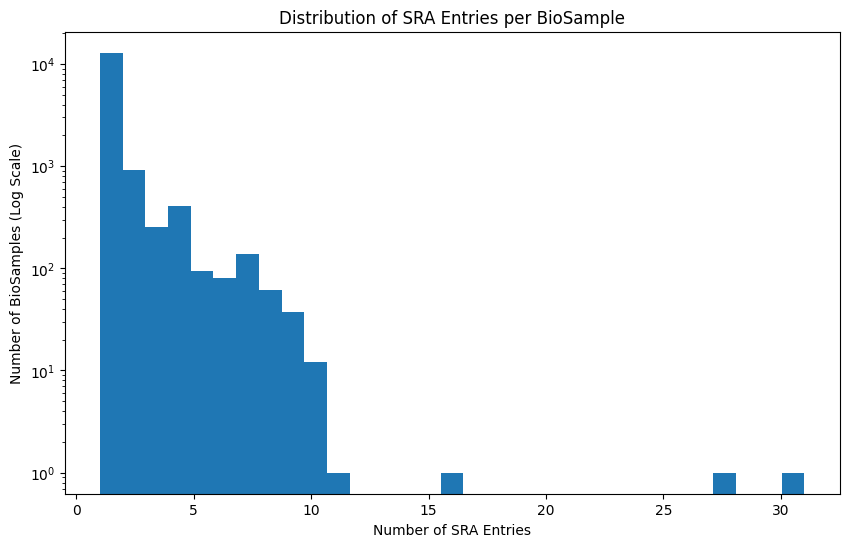

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df = alt_SJ_df
biosample_counts = df['biosample'].value_counts() # Calculate SRA entries per BioSample
plot_data = pd.DataFrame({'biosample_counts': biosample_counts.values}) # Create a DataFrame for plotting

print("BioSample Entries Summary:")
biosample_desc = df['biosample'].describe(include='all')
unique_counts_including_nan = df['biosample'].nunique(dropna=False) # Calculate the unique counts including NaN

# Add the unique counts to the describe output - this is to overcome that Pandas distinguishes between statistical uniqueness (used by `describe()`) and simple value uniqueness (used by `unique()`).
biosample_desc.loc['unique_with_nan'] = unique_counts_including_nan
print(biosample_desc)
if biosample_desc['unique'] < unique_counts_including_nan:
    print(f"There's {int(df['biosample'].isna().sum())} NaN ('Not a number') entries in the 'BioSample' column out of {len(df)} rows.")

plt.figure(figsize=(10, 6))
plt.hist(plot_data['biosample_counts'], bins=31, log=True)
plt.title('Matplotlib log=True')
plt.title('Distribution of SRA Entries per BioSample')
plt.xlabel('Number of SRA Entries')
plt.ylabel('Number of BioSamples (Log Scale)')
plt.show()

There's 14846 BioSamples for the 19997 SRA Entries.  
The skew in the histogram towards the lower number of entries per BioSample is much greater here. How many BioSamples have a specific number of SRA entriesbreaks down like this:   
There's one with 31 and one with twenty-eight and one with sixteen while all others are less than a dozen. In fact the case for those with less than five entries per BioSample reaches numbers about two orders of magnitude larger than what was seen to the right. (If you wanted to investigate in greater detail for specifics of the BioSamples particular, you can run code like `biosample_counts[:21]`. In that, case you'd see the number of entries per BioSample identifier.)

------


That concludes this demonstration notebook. However, you should be able to edit it or take the approach and customize it further to  investigate the data in your own multiple sets of query results.

See the next notebook in this series, - [Examining an Indentified Accession for Presence of a TSL4-rated transcript](Examining_an_Indentified_Accession_for_Presence_of_a_TSL4-rated_transcript.ipynb), where the TSL4-rated transcript is seen in Logan Search identified data.

-----

Enjoy!